## Resources

In [1]:
import os
import shutil
import cv2  #openCV lib

import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import StratifiedGroupKFold

In [2]:
# Function for import data
def data_preprocess_kfold_group_stratify(meta_path, classify, brand, location, fold_chosen, split=5):
    path_bag_loc_df = pd.read_csv(meta_path + 'imagepaths.csv')
    path_bag_df = path_bag_loc_df[path_bag_loc_df.location == location].drop("location", axis=1)
    bag_classify_df = pd.read_csv(meta_path + f'bags{brand}.csv')[['bag', classify]]
    path_bag_classify_df = path_bag_df.merge(bag_classify_df, how='left', on='bag').replace(r'^\s*$', np.NaN, regex=True).dropna(axis=0)
    # Stratified Group K-fold
    path_bag_classify_df['fold'] = -1
    sgkf = StratifiedGroupKFold(n_splits=split)
    for fold, (train_idxs, test_idxs) in enumerate(sgkf.split(X=path_bag_classify_df['path'].values, 
                                                              y=path_bag_classify_df[classify].values, 
                                                              groups=path_bag_classify_df['bag'])):
        path_bag_classify_df.iloc[test_idxs, 3] = fold
    path_classify_df = path_bag_classify_df.drop("bag", axis= 1)
    train_df = path_classify_df[path_classify_df.fold != fold_chosen].drop("fold", axis=1)
    val_df = path_classify_df[path_classify_df.fold == fold_chosen].drop("fold", axis=1)
    labels = np.intersect1d(train_df[classify].unique(), val_df[classify].unique())
    train_df2 = train_df[train_df[classify].isin(labels)]
    val_df2 = val_df[val_df[classify].isin(labels)]
    print(f"Take {fold_chosen}th fold for validation")
    print(f"Train: {len(train_df)} samples, {len(train_df[classify].unique())} classes.")
    print(f"Validation: {len(val_df)} samples, {len(val_df[classify].unique())} classes.")
    print(f"Use intersecting label with {len(labels)} classes.")
    print(f"Using {round(train_df[classify].isin(labels).value_counts(normalize=True)[1], 4) * 100}% samples in train dataset.")
    print(f"Using {round(val_df[classify].isin(labels).value_counts(normalize=True)[1], 4) * 100}% samples in validation dataset.")
    return train_df2, val_df2, labels

In [3]:
# Function create directory
def create_dir(root_dir, class_dir):
    for i in class_dir:
        dirName = root_dir + '/' + str(i)
        try:
            os.makedirs(dirName)
            print("Directory", dirName, "Created")
        except FileExistsError:
            print("Directory", dirName, "already exists")

# 1. Data

- Images are stored in /storage/gcpproddata
- Metadata files are stored in /storage/experiments/matpatclassify/csv
- imagepaths.csv contains image paths (path), bag ids associated with image paths (bag) and the image locations (loc)
- bagsgucci.csv contains bag ids, materials (mat) and patterns (pat).
- You can try to merge those 2 files together by the bag column, then use mat and pat columns for labels.

## Import dataset

In [4]:
meta_path = '/storage/experiments/matpatclassify/csv/'
classify = "mat"
brand = "gucci"
location = 1
fold_chosen = 2

In [5]:
train_df, val_df, labels = data_preprocess_kfold_group_stratify(meta_path, classify, brand, location, fold_chosen)

Take 2th fold for validation
Train: 50908 samples, 85 classes.
Validation: 12707 samples, 43 classes.
Use intersecting label with 41 classes.
Using 97.88% samples in train dataset.
Using 99.69% samples in validation dataset.


(-0.5, 1279.5, 1023.5, -0.5)

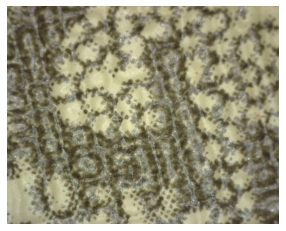

In [6]:
img = cv2.imread(train_df['path'].values[0])[..., ::-1]
img.shape       # (480,640,3)
plt.imshow(img)
plt.axis("off")

# 2. Build inferred structure

## Create directory

In [7]:
shutil.rmtree("/storage/intern")
create_dir(root_dir="/storage",
           class_dir="intern")
create_dir(root_dir="/storage/intern",
           class_dir=["train", "val"])
create_dir(root_dir="/storage/intern/train",
           class_dir=labels)
create_dir(root_dir="/storage/intern/val",
           class_dir=labels)

Directory /storage/i already exists
Directory /storage/n already exists
Directory /storage/t already exists
Directory /storage/e already exists
Directory /storage/r already exists
Directory /storage/n already exists
Directory /storage/intern/train Created
Directory /storage/intern/val Created
Directory /storage/intern/train/GGｻｲｹﾃﾞﾘｯｸｽﾌﾟﾘｰﾑｷｬﾝﾊﾞｽ Created
Directory /storage/intern/train/GGｼﾞｬｶｰﾄﾞﾃﾞﾆﾑ Created
Directory /storage/intern/train/GGﾅｲﾛﾝ(ECONYL) Created
Directory /storage/intern/train/calf Created
Directory /storage/intern/train/canvas Created
Directory /storage/intern/train/coatedcanvas Created
Directory /storage/intern/train/crocodile Created
Directory /storage/intern/train/denim Created
Directory /storage/intern/train/enamel Created
Directory /storage/intern/train/flora canvas Created
Directory /storage/intern/train/fur Created
Directory /storage/intern/train/gg crystal Created
Directory /storage/intern/train/gg embossed leather Created
Directory /storage/intern/train/gg imp

## Transfer data to folder

In [8]:
dir_dict = {
    "/storage/intern/train/": train_df,
    "/storage/intern/val/": val_df,
}

In [9]:
for sub in dir_dict:
    root_dir = sub
    df = dir_dict[sub]
    for i in range(len(labels)):
        classify_path = df[df[classify] == labels[i]]["path"]
        for j in range(len(classify_path)):
            img_path = classify_path.iloc[j]
            dir_name = root_dir + str(labels[i]) + "/" + str(j) +".png"
            print(f"Copying from {img_path[27:]}, to {dir_name[15:]}")
            shutil.copyfile(src=img_path, dst=dir_name)

Copying from /komehyosharing2@gmail.com/rsq2iU/1/1.png, to /train/GGｻｲｹﾃﾞﾘｯｸｽﾌﾟﾘｰﾑｷｬﾝﾊﾞｽ/0.png
Copying from /komehyosharing2@gmail.com/rsq2iU/1/29.png, to /train/GGｻｲｹﾃﾞﾘｯｸｽﾌﾟﾘｰﾑｷｬﾝﾊﾞｽ/1.png
Copying from /komehyosharing2@gmail.com/rsq2iU/1/7.png, to /train/GGｻｲｹﾃﾞﾘｯｸｽﾌﾟﾘｰﾑｷｬﾝﾊﾞｽ/2.png
Copying from /komehyosharing2@gmail.com/rsq2iU/1/10.png, to /train/GGｻｲｹﾃﾞﾘｯｸｽﾌﾟﾘｰﾑｷｬﾝﾊﾞｽ/3.png
Copying from /komehyosharing2@gmail.com/rsq2iU/1/20.png, to /train/GGｻｲｹﾃﾞﾘｯｸｽﾌﾟﾘｰﾑｷｬﾝﾊﾞｽ/4.png
Copying from /komehyosharing2@gmail.com/rsq2iU/1/23.png, to /train/GGｻｲｹﾃﾞﾘｯｸｽﾌﾟﾘｰﾑｷｬﾝﾊﾞｽ/5.png
Copying from /komehyosharing2@gmail.com/rsq2iU/1/4.png, to /train/GGｻｲｹﾃﾞﾘｯｸｽﾌﾟﾘｰﾑｷｬﾝﾊﾞｽ/6.png
Copying from /komehyosharing2@gmail.com/rsq2iU/1/15.png, to /train/GGｻｲｹﾃﾞﾘｯｸｽﾌﾟﾘｰﾑｷｬﾝﾊﾞｽ/7.png
Copying from /komehyosharing2@gmail.com/rsq2iU/1/27.png, to /train/GGｻｲｹﾃﾞﾘｯｸｽﾌﾟﾘｰﾑｷｬﾝﾊﾞｽ/8.png
Copying from /komehyosharing2@gmail.com/rsq2iU/1/14.png, to /train/GGｻｲｹﾃﾞﾘｯｸｽﾌﾟﾘｰﾑｷｬﾝﾊﾞｽ/9.png
Copying from /komehyosharing2@gmail.com/rsq